In [16]:
import tensorflow as tf

import numpy as np
from PIL import Image
import pandas as pd
from keras.models import Model														  

import copy # for deep copies


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(np.__version__)
print(tf.__version__)
print(Image.__version__)

1.22.3
2.9.2
9.2.0


In [3]:
tf.config.list_physical_devices()


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
strArr ="238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 106 96 83 79 79 86 86 81 71 73 95 112 107 111 119 139 200 245 252 252 251 251 250 236 237 237 235 236 239 239 238 239 240 232 201 182 164 121 103 99 83 70 67 72 73 74 73 68 67 75 84 96 107 112 116 121 131 137 143 146 147 146 145 148 148 147 143 148 149 148 148 147 148 149 151 152 153 149 149 149 147 147 150 151 148 150 147 149 147 145 146 141 129 129 129 115 108 108 92 78 80 84 88 87 78 73 74 98 111 104 114 128 145 201 245 253 251 251 250 235 236 236 236 237 239 239 239 239 234 215 186 154 124 103 92 80 69 65 68 69 73 72 71 67 75 86 96 107 112 123 130 141 143 148 149 150 151 147 147 145 150 147 147 147 147 148 149 149 148 153 152 155 150 153 153 152 153 149 150 148 154 149 152 151 149 147 144 147 140 135 127 124 114 114 102 83 80 82 86 88 87 75 71 79 102 110 109 121 129 145 209 247 251 250 251 235 233 236 235 237 236 239 237 235 225 205 161 120 105 95 85 75 66 66 69 68 66 65 67 76 85 97 109 114 126 132 141 142 145 149 152 150 148 149 147 152 145 146 148 149 150 150 150 147 152 152 153 150 153 153 153 151 149 150 147 150 149 153 152 152 151 149 152 146 147 141 137 129 122 112 109 97 82 78 81 87 87 82 73 71 84 99 106 115 136 134 148 215 248 250 249 233 235 234 234 238 239 236 239 231 213 178 124 104 92 85 78 70 71 67 67 69 68 70 76 85 99 113 120 127 134 140 145 143 147 152 153 153 152 152 154 151 151 151 152 152 153 154 153 153 152 154 155 155 156 154 156 154 153 152 154 153 152 152 153 153 151 151 150 148 147 147 143 135 129 120 112 106 92 81 78 87 89 88 77 71 75 92 106 107 123 142 129 164 225 248 249 234 237 234 235 236 237 235 236 222 191 140 102 91 84 80 71 69 73 68 66 65 69 75 90 101 113 121 130 139 141 145 145 146 146 151 151 153 155 152 152 150 157 153 155 153 156 155 155 154 153 157 156 160 155 156 155 156 156 153 159 157 156 153 155 154 153 153 152 152 147 150 144 144 137 129 117 109 103 90 81 83 88 86 84 70 70 84 95 100 107 126 144 148 186 238 250 234 233 232 232 236 236 236 233 219 158 107 90 85 83 71 66 68 69 67 69 71 74 93 105 116 123 131 138 140 145 141 148 148 148 148 154 151 149 151 149 153 151 154 151 152 155 154 153 152 157 153 159 157 159 156 155 159 155 157 156 159 154 156 156 158 157 154 155 154 152 147 147 145 146 136 129 123 108 95 84 83 87 87 86 82 71 72 82 96 101 105 132 145 148 203 240 234 234 233 233 237 235 228 225 185 114 86 83 78 74 66 65 66 66 69 72 78 99 115 123 128 134 139 140 143 144 146 147 147 151 152 152 151 153 153 153 155 155 150 153 153 153 154 153 153 153 156 157 157 159 156 158 161 160 161 165 160 157 156 159 160 158 159 157 154 152 152 150 146 144 141 137 130 123 106 92 90 91 92 90 87 76 70 73 88 96 100 117 135 140 168 218 232 234 234 236 234 228 226 213 146 89 84 78 72 65 64 60 59 69 73 84 104 121 124 132 136 138 141 145 146 146 151 150 152 150 147 148 151 155 157 156 154 154 149 152 154 155 153 153 155 152 155 158 159 158 158 159 160 162 160 165 163 160 157 161 160 157 161 159 157 153 153 147 148 145 145 139 133 136 121 100 89 82 86 86 83 80 72 71 81 90 97 109 120 130 150 192 233 232 233 233 230 222 216 179 99 80 83 76 69 63 64 60 64 69 75 99 124 125 131 134 141 142 145 145 146 149 147 152 149 149 146 150 153 149 154 155 156 152 153 149 153 155 155 154 149 155 159 165 161 161 160 161 161 160 163 158 163 159 159 156 156 158 157 159 154 157 151 150 146 147 144 141 137 135 134 114 94 84 83 85 81 81 74 70 80 88 89 103 119 123 136 170 233 235 235 231 223 221 204 138 89 89 78 67 65 60 61 65 69 74 93 119 124 128 135 141 143 146 145 144 147 147 149 148 148 147 148 148 150 151 149 153 153 154 151 149 151 156 156 154 156 156 160 161 163 161 160 162 163 162 158 157 155 158 156 157 158 159 160 156 153 152 150 147 148 149 146 144 141 141 136 129 108 95 85 83 82 84 84 72 73 81 82 91 106 117 130 146 232 233 233 232 219 217 177 109 97 89 70 62 61 57 60 62 63 78 107 127 131 135 135 144 146 147 147 149 152 150 149 148 150 147 149 146 149 153 150 152 153 154 154 152 150 157 159 158 158 157 160 157 159 156 158 161 160 162 160 159 154 155 154 158 160 160 159 156 155 152 150 151 153 150 149 147 147 143 140 136 121 106 88 81 81 81 82 76 72 77 80 82 92 106 123 133 232 233 235 229 219 195 144 107 88 75 62 59 58 59 56 51 62 92 121 132 138 139 147 148 151 148 150 152 150 153 150 152 149 153 149 152 154 153 156 155 159 156 156 150 151 156 159 162 163 163 157 158 157 161 161 163 159 159 161 155 156 153 155 156 161 162 159 157 153 154 151 153 150 152 150 151 151 145 143 136 131 112 98 85 84 81 80 79 71 77 81 80 86 96 114 122 233 233 232 227 212 168 125 94 79 68 59 56 53 56 51 57 73 103 125 138 144 152 153 155 153 154 152 154 153 152 156 154 155 153 155 157 158 160 159 162 157 156 155 158 155 154 157 156 159 159 161 159 160 159 159 163 161 161 158 160 156 157 154 157 157 157 158 154 155 152 156 150 150 154 152 150 149 150 143 141 132 123 108 95 87 83 78 79 75 74 78 81 87 88 107 116 232 233 232 223 195 152 110 80 74 71 61 53 50 48 48 59 84 111 130 146 151 153 153 155 154 154 153 154 155 155 157 159 159 156 157 158 160 164 163 160 157 156 158 160 159 160 158 156 155 157 159 157 158 157 158 162 162 161 161 159 157 159 160 160 160 161 157 155 155 154 155 152 152 151 151 150 151 152 149 143 134 127 115 109 94 83 77 77 76 71 75 79 84 83 99 112 232 230 230 210 173 134 98 77 70 66 60 49 46 46 44 58 93 120 140 153 159 156 154 150 155 153 152 152 155 162 160 164 162 164 161 163 161 165 166 159 158 153 158 158 163 164 161 160 156 156 157 160 158 164 160 162 161 160 162 156 161 163 167 163 161 163 159 159 154 155 153 158 153 152 150 151 155 152 152 147 145 128 120 120 105 80 74 75 72 70 72 76 81 81 92 104 230 230 221 191 151 112 85 77 70 62 52 47 43 41 41 63 103 128 148 158 158 155 152 154 154 155 155 156 161 162 164 162 166 166 167 163 164 167 164 164 160 159 158 163 165 168 164 159 158 154 159 161 165 162 163 161 160 162 161 162 161 168 169 167 161 159 160 161 163 157 159 156 155 152 152 152 150 153 150 152 147 137 124 120 112 90 74 72 72 71 71 72 76 83 90 97 230 226 209 183 143 94 72 73 64 57 47 41 41 40 45 76 115 139 152 158 159 156 154 155 158 160 161 162 164 164 163 167 169 164 160 164 167 169 168 167 167 167 167 167 168 169 161 157 156 157 160 163 163 164 166 163 163 161 161 163 165 170 171 170 168 165 161 163 165 165 160 157 155 153 152 150 150 152 153 151 149 138 124 119 117 100 76 69 74 69 66 70 74 79 83 96 232 222 201 172 121 73 70 70 63 52 37 40 41 33 44 90 126 146 157 160 160 158 161 159 161 161 163 163 162 163 162 165 162 159 155 164 167 168 171 167 167 165 169 168 172 168 164 162 159 162 165 168 164 167 167 168 165 165 167 164 169 169 172 171 173 174 171 169 169 173 165 162 155 154 151 147 149 151 156 152 152 141 128 123 120 104 83 72 73 71 65 66 70 75 77 93 230 217 197 154 97 66 73 68 59 46 37 38 37 33 55 98 130 150 157 158 155 159 157 162 159 161 161 161 156 156 161 159 153 141 149 156 160 164 166 168 166 169 166 172 173 169 168 165 166 164 171 167 167 165 167 165 163 166 164 166 166 167 165 171 171 176 178 170 169 166 169 164 162 157 155 152 150 153 155 157 151 144 128 126 123 108 88 73 73 71 66 67 68 74 77 88 222 208 182 135 91 70 75 66 54 44 37 38 36 29 56 106 137 149 156 157 159 158 155 154 153 150 149 146 147 148 148 148 142 137 147 154 154 158 163 163 161 164 169 170 171 170 170 167 164 167 169 172 168 164 162 162 161 162 163 164 161 157 158 163 164 173 176 172 166 169 168 166 163 161 158 154 151 154 155 157 156 147 132 128 125 111 89 74 72 71 67 67 65 70 77 88 221 201 164 116 83 70 74 64 52 44 36 35 32 30 63 113 139 150 157 155 152 144 136 130 133 133 131 132 132 133 126 122 122 129 130 133 137 145 151 150 150 152 165 168 168 164 166 167 162 164 167 170 164 159 159 161 161 161 161 160 157 154 155 151 148 155 158 163 164 169 163 162 161 161 157 155 154 149 154 157 159 148 136 129 126 108 87 74 67 69 69 64 62 67 74 84 218 189 137 101 75 68 73 59 51 42 32 31 29 33 77 119 137 148 153 148 135 127 117 114 110 112 114 114 114 116 115 103 96 94 96 97 107 122 129 134 139 151 157 163 165 167 167 164 163 159 163 160 159 155 155 152 154 156 155 159 155 150 143 137 129 133 144 149 151 149 150 150 155 154 157 159 157 156 151 155 155 154 139 130 124 110 87 69 65 67 69 67 60 62 72 82 216 171 121 97 74 72 71 58 51 41 32 32 26 36 79 124 138 137 127 115 113 106 101 101 104 104 98 92 98 100 97 95 85 77 75 74 84 104 116 121 130 148 162 161 160 162 165 163 160 162 161 159 154 151 146 142 143 145 148 143 140 133 123 114 112 117 124 127 127 129 129 129 129 133 143 152 159 161 156 150 155 152 145 130 126 110 84 67 61 64 71 69 61 60 73 83 209 157 117 92 69 72 73 60 50 38 30 30 24 40 88 123 125 121 109 99 98 100 99 96 101 99 97 99 99 98 93 84 75 73 70 70 78 94 107 112 120 134 152 156 153 151 158 157 153 156 159 159 156 146 135 137 138 141 137 130 118 115 109 99 94 95 103 110 115 121 119 115 117 122 123 128 144 157 160 154 152 149 144 131 130 109 78 61 61 69 69 69 60 59 70 80 197 145 112 85 68 73 70 58 49 42 31 28 23 42 94 116 123 120 108 100 102 112 107 100 95 93 96 99 92 88 86 81 77 74 75 73 73 79 90 98 109 126 137 149 143 143 153 153 148 147 154 154 151 132 127 133 133 135 128 115 105 100 94 88 85 91 93 102 114 116 120 119 119 115 117 118 123 146 158 156 148 149 143 136 125 103 74 55 61 69 65 66 57 56 70 79 183 137 106 80 68 69 68 55 47 41 34 31 22 49 94 113 117 116 111 106 106 106 107 104 103 103 95 88 90 89 87 86 84 79 77 80 83 84 84 92 109 117 130 139 134 138 147 153 156 152 145 147 136 121 114 123 129 127 118 102 92 88 84 77 80 94 95 91 92 103 116 124 123 126 128 127 122 125 139 144 147 143 142 135 120 98 70 57 65 69 62 66 59 56 67 77 168 126 99 79 69 68 63 53 49 43 37 28 26 56 99 108 102 109 115 116 114 111 110 112 113 113 109 103 99 99 96 93 89 86 82 84 89 89 90 92 99 108 120 125 126 134 147 153 159 157 145 135 132 126 123 127 121 115 108 95 83 80 80 79 84 89 96 97 96 107 123 130 132 138 130 122 118 120 133 135 138 141 141 130 118 95 66 56 68 70 60 63 62 56 65 78 150 118 94 73 67 68 61 56 49 44 39 27 27 60 98 106 108 110 115 121 119 119 114 115 113 114 117 119 115 110 108 105 101 94 93 93 96 97 98 100 98 106 115 124 128 138 150 157 161 159 151 135 136 134 129 123 111 104 103 100 93 96 95 96 98 100 105 107 108 113 121 122 122 121 121 118 119 124 127 135 134 136 137 127 116 95 63 57 67 68 57 57 61 58 62 72 139 105 86 72 66 64 62 56 51 45 38 29 29 65 98 110 113 118 119 119 119 118 121 119 120 118 112 108 105 102 99 97 89 84 83 89 96 98 102 104 108 110 119 124 135 146 154 159 161 158 141 135 133 127 116 111 111 112 112 109 108 108 107 106 108 112 113 114 119 123 119 120 116 117 117 123 129 125 125 131 135 131 128 122 115 94 64 60 70 61 52 54 57 57 59 71 130 99 80 73 66 64 61 53 52 49 42 28 33 71 106 112 115 117 116 117 116 117 117 105 95 95 98 96 96 97 97 97 96 91 83 77 84 93 101 106 110 112 115 124 137 151 162 164 164 162 148 133 128 119 112 114 115 118 115 112 110 109 112 115 117 118 123 121 120 121 120 123 124 122 121 127 128 125 126 126 129 130 128 124 113 90 63 58 66 55 45 53 57 55 61 73 119 94 77 71 67 61 55 54 50 47 38 28 38 74 114 120 119 119 116 118 116 102 91 94 101 102 98 90 84 86 84 83 100 112 111 97 83 84 94 105 110 114 117 130 142 155 160 161 162 163 159 140 125 115 117 118 119 116 108 103 96 93 89 97 104 111 114 117 123 124 124 121 124 120 123 124 121 127 129 123 119 120 121 122 112 92 62 54 61 52 45 48 55 55 61 74 113 88 81 72 66 61 56 52 52 48 39 30 34 87 130 134 127 122 119 113 90 88 114 111 93 87 97 86 65 65 71 67 66 80 99 108 99 89 92 100 109 111 121 132 151 154 156 157 155 158 150 139 127 124 122 120 115 109 101 89 86 91 101 104 107 111 106 98 102 112 112 117 120 122 120 120 122 126 129 122 120 122 125 118 113 93 68 59 57 49 45 49 55 56 58 68 106 87 82 71 63 60 54 52 51 48 43 27 37 95 138 135 125 120 113 89 83 109 107 81 84 128 140 89 96 96 58 90 90 74 96 100 105 103 97 101 108 114 120 139 154 157 156 153 154 154 150 135 129 129 123 116 110 101 93 92 103 113 116 107 102 102 92 88 99 102 107 109 105 107 115 118 119 125 126 125 126 127 126 123 115 94 65 56 56 43 41 46 53 54 58 70 99 88 78 67 60 59 54 51 52 48 41 24 44 104 139 135 128 118 104 96 100 92 72 85 124 166 146 77 86 96 72 84 85 83 135 125 94 104 110 111 111 115 127 149 157 158 150 150 153 156 150 134 131 126 121 113 108 101 99 107 112 109 98 95 82 74 74 78 84 84 90 97 109 108 100 111 116 115 121 126 126 124 123 123 111 96 64 51 53 41 41 47 53 54 57 72 94 85 78 65 60 58 52 49 51 48 37 29 50 116 142 142 129 118 113 112 101 92 96 111 139 168 151 83 74 81 80 85 76 91 147 145 109 92 107 118 120 117 141 156 160 155 152 149 149 156 148 138 130 127 121 114 113 110 113 111 100 110 135 110 91 88 89 88 78 99 111 94 101 116 102 93 108 114 116 120 128 128 128 120 113 94 66 54 51 39 37 48 52 54 57 71 95 84 71 62 61 59 52 49 51 46 33 24 64 125 153 147 134 122 117 121 126 131 122 120 129 152 157 116 82 81 88 88 85 114 138 127 109 95 101 121 121 128 150 164 160 155 149 146 148 153 150 139 134 128 124 123 123 118 107 98 114 163 155 96 126 93 72 125 98 90 145 130 96 86 103 97 92 113 122 125 129 129 131 129 116 95 66 51 50 37 34 47 54 49 58 72 88 82 71 59 56 56 48 50 52 44 29 25 79 140 159 150 138 129 128 131 136 138 131 122 112 113 122 123 112 107 105 110 119 126 122 114 110 109 116 124 123 137 157 165 159 155 147 142 146 150 149 141 135 128 130 131 121 107 103 106 131 164 142 86 100 86 66 94 90 88 144 156 115 84 87 97 94 105 121 124 129 131 134 134 118 97 62 48 47 34 33 45 52 51 58 69 85 77 67 57 56 54 49 48 53 43 28 37 93 156 160 153 145 143 141 139 140 140 140 131 122 111 112 113 115 116 121 128 125 122 114 116 121 125 128 128 133 144 165 167 165 152 145 144 146 149 148 146 136 133 128 132 120 106 105 109 123 148 144 97 91 89 83 90 78 95 158 159 125 98 85 93 105 104 114 123 130 132 141 134 120 95 62 52 47 34 32 41 47 52 60 65 81 75 61 53 56 53 43 44 47 41 30 45 122 161 163 155 153 153 151 149 146 146 139 135 130 127 125 124 121 119 118 115 112 107 112 113 113 118 128 135 143 157 162 170 158 152 146 148 148 147 153 144 136 134 132 132 131 129 122 120 121 132 139 120 99 100 99 87 80 131 171 153 128 113 107 102 109 118 119 123 127 135 140 140 123 95 60 48 50 36 34 42 48 47 59 66 77 69 57 52 54 52 46 46 46 41 29 64 136 164 164 160 157 157 157 155 148 146 140 136 128 122 120 123 126 126 125 124 120 118 119 116 118 131 139 143 153 159 168 177 158 151 151 152 147 149 154 144 137 139 139 133 126 129 127 121 124 126 128 131 127 122 112 105 114 131 133 126 123 127 130 125 122 123 124 127 133 145 150 145 125 96 61 49 52 37 33 40 45 47 55 59 75 66 55 50 52 47 46 46 47 41 31 86 148 168 165 163 158 163 161 156 154 151 153 146 144 141 139 141 143 142 139 135 126 123 121 128 133 143 147 153 159 159 169 168 160 152 150 147 149 153 156 152 142 146 145 140 128 124 125 121 121 120 128 125 129 129 125 122 114 111 114 129 132 137 142 144 137 132 130 134 146 150 153 144 132 96 57 47 49 39 34 37 40 47 55 56 75 66 53 50 52 48 41 43 48 37 48 108 161 168 167 163 166 166 162 155 151 153 148 149 146 148 145 144 143 142 141 134 130 129 138 142 148 147 152 162 158 158 163 167 155 151 150 148 152 157 154 147 144 141 147 145 140 129 124 130 128 128 128 133 135 137 138 138 137 137 137 138 141 142 149 147 143 141 139 144 147 152 149 147 133 98 59 47 48 39 35 34 38 45 55 60 73 63 51 51 51 42 39 44 46 37 67 140 168 168 167 166 164 164 165 160 157 156 154 151 149 146 144 142 143 145 141 138 137 143 149 154 156 156 162 164 159 156 159 159 154 148 148 151 153 155 150 145 143 144 145 147 146 137 131 128 130 134 138 143 142 141 142 143 142 143 142 140 141 148 151 149 152 154 156 155 154 155 155 148 134 97 59 52 51 40 36 38 40 45 53 60 67 60 52 50 48 39 37 44 42 39 89 155 168 167 164 167 163 165 164 164 161 158 157 152 150 145 145 145 144 143 140 144 146 157 157 160 160 162 165 163 159 152 151 151 156 151 154 149 146 144 141 139 140 146 146 148 147 146 142 137 135 134 142 149 152 148 148 144 142 142 139 140 145 154 154 156 160 163 165 164 162 158 159 150 136 99 59 50 54 41 34 38 41 44 52 54 62 55 48 46 42 38 37 39 39 43 117 162 169 165 168 166 167 162 164 162 156 158 152 151 147 147 146 150 148 145 148 150 156 159 163 162 164 164 164 161 154 154 154 157 147 153 157 157 149 140 137 135 139 143 150 148 150 149 149 147 138 140 139 143 147 156 157 154 154 150 150 150 156 157 162 160 161 167 168 167 162 163 157 151 139 102 55 49 51 41 33 37 40 42 50 57 61 53 47 44 41 37 36 40 33 57 133 165 168 168 166 167 164 163 160 160 159 154 151 147 147 146 150 153 154 156 154 159 162 162 163 167 164 163 163 157 155 162 173 162 150 148 151 155 154 151 140 137 137 147 147 147 148 151 155 150 147 144 142 142 147 153 155 157 158 159 158 159 158 160 162 163 168 169 168 164 164 161 157 151 142 104 59 49 53 44 33 35 37 40 50 56 60 55 48 43 40 35 34 38 34 74 142 165 168 170 165 167 166 164 161 164 163 157 153 150 153 153 156 155 157 159 161 163 162 166 169 169 163 164 159 157 156 164 173 161 154 148 151 152 155 153 141 137 138 147 149 152 149 152 152 152 153 152 151 146 147 149 149 155 156 156 155 158 156 162 164 167 172 169 166 164 168 163 160 150 140 103 58 49 53 44 38 39 39 40 46 55 59 53 48 40 37 37 38 38 32 82 147 163 166 165 167 164 166 164 166 163 160 158 151 156 157 159 156 159 160 161 162 160 163 162 171 164 160 155 154 154 155 164 165 158 152 159 152 155 154 147 140 136 141 142 149 149 152 154 153 156 152 156 153 155 151 150 151 151 154 155 159 158 161 161 167 170 171 169 165 166 163 165 157 152 146 112 59 48 51 41 36 40 42 41 43 53 58 50 45 39 37 36 36 35 33 95 155 167 164 164 166 164 161 163 163 160 160 161 163 162 162 161 164 160 162 164 163 163 161 169 167 162 152 146 146 149 156 164 167 153 152 155 154 154 155 151 141 140 138 138 146 152 155 158 159 155 156 158 158 154 154 149 153 157 152 157 160 163 164 165 165 167 168 168 165 162 162 162 160 149 149 120 68 47 47 42 35 33 38 44 44 50 56 49 42 37 36 37 39 35 35 100 159 168 166 167 165 163 163 165 160 162 161 161 164 166 164 163 166 166 164 163 163 161 162 166 162 155 145 145 144 151 159 164 164 155 156 155 160 156 153 151 144 140 136 138 142 149 153 159 162 160 158 161 163 159 158 154 157 156 151 154 157 160 163 167 165 165 164 163 160 157 159 160 159 149 149 129 82 55 48 39 34 36 34 39 47 53 54 47 40 36 36 36 39 33 34 99 161 166 165 165 168 160 162 162 160 160 160 162 163 165 163 168 165 167 163 162 162 159 162 158 156 149 149 153 155 159 166 170 161 163 158 161 162 159 151 152 146 139 140 137 137 140 146 153 159 162 159 162 161 163 159 158 160 161 157 153 161 159 163 164 168 164 163 162 160 162 158 160 153 147 144 137 87 58 48 41 35 35 37 34 43 53 53 44 39 35 34 36 37 32 32 102 160 166 161 164 163 162 162 164 158 161 166 164 168 168 169 167 166 161 162 161 157 158 155 153 148 156 163 168 169 171 180 167 165 161 163 163 165 163 156 155 149 142 135 136 132 138 146 153 157 156 160 159 158 157 160 159 161 164 163 165 164 167 163 167 165 163 162 159 158 156 154 153 150 140 144 141 99 64 50 39 34 32 39 38 39 49 55 43 37 35 33 37 39 28 32 102 157 164 159 158 158 160 163 159 158 163 164 164 166 166 164 162 165 165 164 163 158 155 150 146 148 152 151 159 162 162 164 167 172 168 164 166 169 169 161 155 154 148 145 145 138 134 142 153 155 158 158 156 155 155 160 163 164 167 169 167 165 164 164 168 165 161 162 157 150 151 152 152 147 142 142 140 111 70 50 40 35 32 37 40 41 48 51 40 34 36 35 38 39 24 27 102 156 161 157 151 155 155 153 146 155 159 162 165 163 164 162 163 162 166 159 158 157 152 148 144 148 133 126 138 146 145 150 158 165 170 164 168 166 166 159 150 147 144 149 148 150 140 138 148 151 157 158 161 156 159 161 166 162 167 168 166 169 166 164 163 164 162 165 157 149 151 149 149 145 140 138 141 112 73 52 42 41 36 37 38 35 45 48 36 34 36 35 39 40 28 29 104 156 159 154 156 156 153 142 144 151 154 159 164 166 160 164 162 163 158 158 158 156 152 144 146 139 120 92 80 111 138 148 150 159 160 158 155 157 160 152 138 131 136 139 138 138 142 141 143 148 151 157 159 164 162 164 162 162 163 166 168 166 171 165 163 162 167 162 155 151 147 149 144 143 136 133 132 109 74 50 43 41 38 39 39 35 35 48 36 34 35 35 41 41 28 26 102 158 157 152 151 152 148 144 147 151 156 161 164 164 163 162 163 161 160 161 157 151 148 143 140 131 115 92 60 47 89 133 145 148 146 140 140 146 149 136 122 123 125 122 119 124 134 139 141 145 154 156 161 163 162 162 162 166 165 168 165 169 168 165 163 160 161 158 156 153 150 145 144 140 131 131 127 103 73 52 45 42 38 37 40 37 33 43 38 38 37 39 43 43 28 21 104 162 154 150 146 143 144 146 145 146 149 157 162 164 168 164 164 158 159 157 151 146 146 144 134 128 121 110 87 58 29 72 130 133 130 130 135 137 130 117 111 104 76 68 92 117 129 134 137 147 154 154 162 163 166 162 165 165 167 167 164 168 166 165 156 159 157 154 153 155 152 145 144 141 131 126 120 96 73 55 46 45 38 34 39 39 36 43 36 35 35 40 42 41 30 31 109 158 152 150 150 142 145 145 141 143 148 156 159 167 162 162 159 157 155 155 148 146 152 144 135 121 120 121 115 98 78 99 127 120 112 115 115 114 109 99 71 46 48 68 94 111 128 134 140 149 154 157 156 163 162 166 166 165 166 164 166 163 162 156 156 155 155 151 148 150 150 146 141 138 126 123 113 90 69 56 49 45 41 37 36 38 36 38 34 35 34 34 38 39 30 32 115 159 150 151 151 146 142 140 140 143 152 160 160 159 160 158 157 156 157 154 151 149 148 144 136 125 114 121 126 125 128 133 132 123 109 102 104 103 101 101 91 82 87 104 115 124 127 127 140 152 156 151 154 155 161 167 166 164 163 162 160 161 159 157 155 151 152 151 150 148 145 141 137 131 124 122 109 79 59 55 61 56 41 36 36 35 35 37 35 33 33 33 36 39 31 32 119 159 149 153 149 147 141 140 142 148 155 160 162 160 161 155 155 152 155 152 150 150 148 146 142 138 122 117 126 135 128 129 133 131 119 106 114 117 112 115 118 117 120 123 122 121 116 123 138 151 156 154 155 156 162 162 167 164 164 161 161 160 156 154 148 149 149 148 147 148 146 141 139 127 124 124 102 69 56 57 67 62 47 40 41 36 33 39 36 34 32 32 33 38 32 39 126 158 149 150 148 140 143 142 144 147 154 161 167 168 161 158 150 153 149 150 153 152 151 144 136 128 121 111 111 103 97 110 125 132 125 123 125 129 124 112 111 112 117 116 110 107 116 128 139 150 156 158 156 161 162 166 166 167 162 160 161 156 155 150 150 143 141 139 143 145 142 142 133 127 125 117 84 59 53 56 66 69 56 41 43 37 34 37 35 32 30 31 35 43 35 44 127 155 151 151 146 144 142 145 143 149 155 163 170 162 161 158 158 153 157 156 157 156 144 124 109 106 104 96 87 77 82 93 113 129 132 133 140 136 121 100 90 89 93 108 113 120 127 134 139 146 153 155 159 158 162 166 165 165 160 160 160 158 154 150 146 143 139 141 142 143 143 139 133 129 124 104 74 57 51 61 75 76 60 41 40 40 31 38 34 33 29 30 40 57 52 56 120 148 152 148 145 142 141 145 145 151 156 164 164 160 160 157 154 156 165 163 155 147 127 104 94 90 84 80 77 75 80 85 99 125 142 146 146 131 108 93 79 63 75 92 101 111 122 134 140 147 153 155 156 156 162 162 166 164 161 160 161 158 153 149 144 144 143 144 143 143 144 140 134 132 124 81 63 63 52 68 78 79 67 43 36 38 33 43 38 31 25 29 38 62 59 60 125 153 152 146 145 143 144 141 147 149 156 159 158 162 156 156 159 168 160 151 141 129 113 97 88 79 77 77 75 74 75 84 96 117 137 151 142 117 101 93 85 71 73 82 88 94 111 129 143 150 156 158 156 160 157 164 163 165 162 159 159 155 154 149 146 141 143 146 146 144 140 140 134 133 118 72 63 63 57 71 81 83 67 42 37 38 34 46 38 24 24 27 36 53 57 68 128 148 143 143 144 143 140 145 145 148 156 160 159 147 143 156 162 149 139 129 123 110 101 90 76 73 74 74 71 69 74 82 93 111 134 141 131 107 92 86 83 71 68 73 78 84 97 120 137 145 153 157 162 157 157 154 157 163 164 160 154 155 154 154 146 143 144 146 146 143 142 139 134 133 105 68 74 64 64 75 78 84 69 46 40 38 34 41 30 24 25 23 34 50 61 78 129 144 140 138 141 144 142 140 144 151 158 160 151 139 147 151 137 128 115 102 97 93 83 75 72 72 70 71 69 65 74 84 89 102 118 123 116 109 97 82 75 70 62 62 70 81 92 110 122 135 146 149 152 157 160 150 154 161 161 157 155 154 150 150 151 149 147 147 144 140 142 138 131 132 97 72 77 69 74 74 74 84 70 49 41 36 33 35 29 22 24 23 30 55 69 87 126 141 142 138 140 140 144 145 149 156 161 158 148 146 142 126 117 109 90 82 81 80 74 65 67 67 64 65 67 68 74 86 92 112 127 123 110 111 103 87 75 70 63 59 63 73 86 94 104 117 125 131 142 153 152 150 145 156 159 153 154 154 153 147 150 147 145 143 144 141 138 136 132 123 84 73 79 78 81 75 79 83 67 54 42 34 34 30 29 21 17 18 31 51 68 90 123 136 138 142 136 139 144 150 153 159 156 150 146 146 127 104 102 86 73 70 76 72 66 66 62 62 62 59 61 65 74 86 108 125 127 115 113 113 109 89 73 67 64 63 57 64 68 72 83 96 106 110 127 140 154 154 149 149 156 156 151 155 154 150 148 149 146 146 144 139 140 133 129 118 81 70 74 80 88 78 82 90 70 51 38 32 35 31 30 24 16 12 17 39 64 93 128 135 138 139 137 138 143 148 153 156 157 148 153 150 113 87 81 76 66 66 71 64 57 62 64 60 60 59 62 62 69 98 124 133 126 121 120 118 108 90 79 66 61 61 61 64 64 62 66 79 89 93 97 116 142 156 150 141 151 156 154 154 152 149 151 146 148 146 139 138 133 130 128 118 89 90 97 107 117 99 98 95 67 45 35 33 32 40 40 32 23 15 13 22 48 86 125 136 134 128 131 136 140 144 151 155 157 151 160 137 98 79 70 68 63 65 67 62 61 64 63 58 58 60 66 63 70 107 127 135 131 135 135 124 105 90 75 65 64 64 69 65 63 61 59 63 71 75 78 89 108 140 149 141 146 155 155 153 153 149 152 146 146 141 140 140 131 128 124 106 92 116 132 145 140 121 110 90 57 37 39 37 32 40 38 31 25 20 16 13 12 53 129 141 131 127 129 135 135 142 145 154 149 150 149 117 86 73 69 61 61 67 69 63 59 64 64 64 61 57 62 64 72 95 117 129 140 137 129 110 97 85 68 61 63 70 71 67 64 63 63 59 60 65 70 67 83 120 144 143 147 156 155 154 151 152 150 149 146 142 139 135 133 132 127 95 95 127 140 142 138 114 96 80 47 35 48 44 34 36 31 28 26 24 21 16 2 39 127 143 135 127 125 126 138 139 142 149 148 151 144 99 73 71 68 60 57 64 67 59 56 56 61 57 52 54 56 64 81 94 97 107 119 115 100 92 86 74 62 65 73 75 76 71 69 64 65 60 58 60 59 63 71 105 140 150 149 154 157 154 152 151 147 147 148 142 134 134 132 131 124 90 111 144 144 143 132 111 101 80 36 33 46 51 38 37 36 28 20 19 19 16 8 37 119 146 144 138 131 128 130 133 140 143 149 156 138 91 72 68 65 57 52 55 58 55 52 51 51 55 53 52 57 68 88 96 102 107 112 111 102 97 86 74 70 71 71 70 77 70 70 67 68 63 60 60 56 61 69 95 132 150 148 152 155 153 152 150 146 141 139 138 139 135 129 123 106 87 119 148 145 145 133 120 104 65 28 35 53 68 55 37 33 29 20 16 15 14 5 35 129 150 140 138 142 139 134 141 136 141 149 154 123 88 70 62 60 55 52 49 47 47 45 50 57 58 56 58 65 72 74 79 88 93 98 91 82 74 78 77 75 74 73 69 65 63 66 72 71 68 68 63 59 61 67 82 115 142 151 151 154 154 147 149 145 136 131 140 142 136 129 121 103 81 117 148 147 140 137 123 91 42 28 36 51 75 72 25 21 19 17 17 16 13 5 34 119 144 134 132 143 137 133 135 140 143 152 154 115 77 65 61 57 56 57 54 50 48 54 58 62 64 67 77 89 101 107 109 108 107 100 99 96 95 91 88 85 79 76 69 64 59 59 58 62 67 70 66 67 66 57 71 100 132 149 152 153 151 146 145 144 139 141 139 137 134 132 126 107 85 111 142 140 136 134 115 58 24 28 33 48 70 85 19 18 17 18 16 17 19 11 30 111 135 132 135 136 132 131 140 146 140 148 150 110 76 64 59 59 59 59 61 58 57 66 81 89 89 91 95 100 109 118 123 127 128 125 126 124 122 113 109 102 93 84 81 78 69 71 66 63 60 57 58 68 69 57 62 85 118 144 152 152 148 144 137 136 139 141 135 134 134 130 127 104 87 111 131 134 135 120 67 25 24 29 32 46 62 83 27 24 20 18 16 16 15 7 16 93 135 136 134 132 134 134 142 137 136 143 146 113 78 63 61 64 66 69 68 76 82 85 105 121 130 127 127 127 126 121 125 133 130 132 130 133 128 127 118 114 112 106 108 108 109 104 97 83 78 72 63 63 65 60 60 77 116 143 147 149 145 136 135 136 140 134 131 133 131 127 124 102 74 87 101 108 90 53 24 26 30 29 32 39 59 78 29 31 28 22 19 17 17 11 18 86 135 134 132 134 131 140 140 139 137 140 144 121 85 69 64 68 71 81 95 102 106 117 122 130 135 140 141 141 136 133 136 137 144 144 143 139 142 141 137 137 134 137 138 134 124 118 109 101 90 86 79 71 63 61 60 73 116 142 146 144 138 136 137 135 130 131 133 134 129 129 118 93 50 22 23 29 28 24 29 30 29 31 33 35 48 68 25 26 29 30 25 23 23 14 11 73 127 133 133 132 135 141 138 138 136 137 142 128 93 74 67 71 83 91 103 115 121 126 126 126 128 134 133 131 127 122 117 120 130 131 126 126 131 135 136 136 136 138 139 135 128 124 117 111 105 101 86 71 74 73 57 71 118 138 138 138 134 135 138 132 129 135 134 130 130 131 115 81 48 23 20 24 25 27 28 30 30 31 33 34 44 57 30 26 25 31 31 28 27 24 14 55 124 137 129 130 136 132 138 137 140 139 142 133 104 82 74 80 95 109 116 122 125 128 128 125 125 122 118 116 110 102 92 88 91 90 86 89 102 113 118 122 119 118 127 129 127 122 124 120 113 102 88 85 85 75 56 80 119 129 132 139 131 128 134 132 134 129 129 129 130 125 110 73 42 26 24 28 27 26 27 28 32 36 36 35 40 53 33 32 30 26 34 35 27 29 20 33 109 137 131 135 130 132 140 144 139 138 136 132 114 111 111 106 119 121 125 128 127 128 125 125 120 113 106 101 89 85 78 74 80 77 70 67 77 89 97 103 107 110 112 125 124 125 124 115 103 102 106 100 91 74 63 95 124 123 129 132 126 132 133 139 137 136 131 130 131 127 98 56 33 28 25 28 28 25 29 34 34 37 44 41 37 45 30 29 29 27 31 37 33 28 30 28 87 136 137 136 136 141 142 139 140 140 135 133 128 124 127 132 136 132 126 125 123 125 119 111 106 96 85 78 71 62 58 62 61 57 57 59 57 65 80 96 108 116 126 130 133 130 124 123 124 127 118 105 93 77 90 113 126 125 122 124 130 133 139 141 137 135 133 128 125 116 84 40 31 28 24 23 26 30 35 38 36 34 38 46 45 44 38 31 30 28 26 33 38 29 27 24 62 126 136 131 133 137 139 140 145 141 134 137 131 125 134 140 137 138 131 127 120 119 112 103 94 82 74 66 62 53 45 46 42 35 40 53 53 50 57 72 87 104 121 125 129 128 127 126 127 127 119 108 98 104 117 130 130 126 118 124 135 129 126 127 130 130 133 128 121 110 76 35 26 24 20 20 23 28 33 35 36 40 43 45 46 50 39 35 33 32 23 26 36 32 25 23 33 101 129 130 131 138 134 138 140 136 126 125 126 128 128 123 136 137 129 118 114 104 97 93 81 72 66 62 54 46 41 44 44 41 43 49 55 52 56 67 74 88 103 118 119 123 125 130 128 126 126 123 125 128 133 133 133 130 127 133 137 133 125 126 129 131 128 123 116 104 61 28 21 19 19 22 23 27 33 34 38 39 41 44 45 47 39 33 34 36 25 21 29 34 28 23 23 63 116 128 134 140 144 146 144 139 136 133 129 126 111 118 132 127 117 111 104 93 81 70 62 56 51 45 42 42 46 46 45 45 43 50 55 54 63 70 76 84 97 108 113 119 128 128 130 131 136 141 139 138 137 134 133 137 137 138 133 128 126 129 132 130 124 117 116 93 45 22 21 20 22 24 24 25 27 28 32 36 37 41 46 50 57 37 33 35 33 26 24 30 31 25 20 32 90 125 132 139 141 143 146 144 145 138 126 112 108 120 119 117 111 105 98 89 75 64 62 55 47 44 47 47 47 47 50 52 46 50 54 55 67 73 77 82 92 102 113 122 130 132 135 140 145 147 145 141 138 137 137 140 138 138 130 117 127 132 131 127 125 121 112 69 28 17 20 21 21 23 25 24 25 28 34 36 39 41 43 48 94 50 34 35 37 30 23 25 33 29 26 24 44 101 123 135 135 141 144 148 144 138 121 107 108 111 111 100 106 107 96 80 66 62 59 52 48 51 50 47 44 54 58 51 49 54 57 53 63 71 75 79 83 101 112 126 130 136 135 135 142 146 147 140 139 135 138 139 140 138 134 133 131 129 127 127 120 119 87 39 21 18 19 19 22 23 25 27 27 33 35 34 38 45 53 58 131 71 38 34 37 34 26 24 29 28 26 23 19 48 101 122 138 142 142 144 150 141 118 105 103 106 98 102 104 102 88 61 52 51 51 50 50 48 45 41 46 58 56 47 49 57 61 60 61 62 69 79 86 98 113 119 128 135 140 144 142 138 136 138 138 138 138 139 139 139 139 138 135 130 125 122 119 99 55 25 19 21 20 18 22 24 28 29 30 35 38 40 45 44 49 57 166 121 57 33 36 36 29 25 27 29 28 26 22 15 50 103 126 135 141 142 153 139 116 106 95 98 103 105 93 87 64 50 47 46 45 47 54 50 44 45 47 50 48 41 51 62 61 64 60 52 59 70 75 89 114 121 125 132 145 148 145 136 128 135 139 141 142 141 138 140 136 133 131 126 122 113 103 62 26 22 22 21 24 21 21 24 25 29 29 32 38 42 48 55 53 53 179 167 112 44 29 35 32 24 24 31 29 27 29 16 10 64 111 129 135 146 145 128 114 106 98 105 109 88 76 68 59 46 40 41 43 44 48 47 41 47 45 42 44 46 53 61 56 58 58 50 48 56 61 75 104 129 131 138 144 149 146 135 125 131 144 145 146 141 135 133 132 130 124 119 115 108 65 24 18 20 22 24 24 22 22 25 26 29 31 32 35 41 43 48 54 56 186 183 181 104 30 31 34 27 24 29 30 28 31 20 14 51 98 116 130 139 136 113 96 86 86 98 89 77 64 51 52 47 40 38 40 41 43 41 39 43 39 38 42 45 49 55 51 50 52 48 45 44 52 56 92 128 134 132 141 146 145 143 134 137 146 150 146 140 136 131 129 126 120 111 110 89 32 17 21 20 20 24 27 25 23 23 26 28 29 32 39 45 48 52 57 60 189 188 207 172 69 31 36 30 26 31 32 30 29 19 14 56 95 102 112 133 128 90 67 73 75 76 76 70 53 46 48 44 40 39 35 34 39 43 35 36 39 37 38 42 44 43 42 43 45 46 41 40 46 48 60 112 136 131 135 140 138 139 138 142 146 148 145 138 131 128 126 121 110 107 107 79 25 14 18 19 22 25 28 30 29 29 28 30 31 34 41 48 54 61 69 78 191 184 184 192 127 44 33 27 25 28 29 27 25 17 13 58 97 104 101 120 117 93 72 62 64 67 68 59 51 46 46 45 39 35 31 33 40 46 41 38 38 38 38 38 40 37 37 40 41 39 35 36 42 44 45 97 130 131 133 135 124 126 133 136 146 143 136 132 127 124 119 110 104 112 119 78 20 17 19 20 23 26 31 30 30 32 33 29 30 34 39 49 62 70 75 90"


In [5]:
# https://www.kaggle.com/competitions/facial-keypoints-detection/data

newArr = strArr.split(" ")
newArr = np.array(newArr,dtype=np.uint8)

newArr= np.reshape(newArr, (96,96))
print(np.shape(newArr))

newImage = Image.fromarray(newArr,mode="L")

# How training data is organized
"""First 30 Columns are the x and y coordinates of each of the landmarks and the 31st column is a huge matrix of 96x96 grayscale pixel values that create an image. This is all stored in one row
Next row is the same concept, with landmark coords and the last cell in the row is another huge matrix"""


# How to train images with the landmark points
# Source/Inspo: https://fairyonice.github.io/Achieving-top-5-in-Kaggles-facial-keypoints-detection-using-FCN.html


(96, 96)


'First 30 Columns are the x and y coordinates of each of the landmarks and the 31st column is a huge matrix of 96x96 grayscale pixel values that create an image. This is all stored in one row\nNext row is the same concept, with landmark coords and the last cell in the row is another huge matrix'

In [6]:
df = pd.read_csv('faceLandmarkTraining.csv') 

In [7]:
#print(df)
#print(df.iloc[2])

df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
# print("After .apply")
# df.head()

In [8]:
#reshaping the 1D arrays in the pandas dataframe to 2d numpy arrays


for i in range (0, df.shape[0]) :
    sample = df.iloc[i,30]
    
    reshaped = sample.reshape(96, 96)
    df.iat[i,30] = reshaped

print("2284th row: {}".format(df.iloc[2283,5]))
print("Row 2283 aka the 2284th row is the last row to contain most of the landmarks")
print("2285th row: {}".format(df.iloc[2284,5]))

#however there are other missing data values in the 1500- 1900 range so we gotta remove these ones

print("Original Shape {} ".format(df.shape))

df = df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=False)
print("Dropped Shape {} ".format(df.shape))


2284th row: 36.0651428573
Row 2283 aka the 2284th row is the last row to contain most of the landmarks
2285th row: nan
Original Shape (7049, 31) 
Dropped Shape (2140, 31) 


 All Left Eye centers have had the pixels at their coordinates changed to white


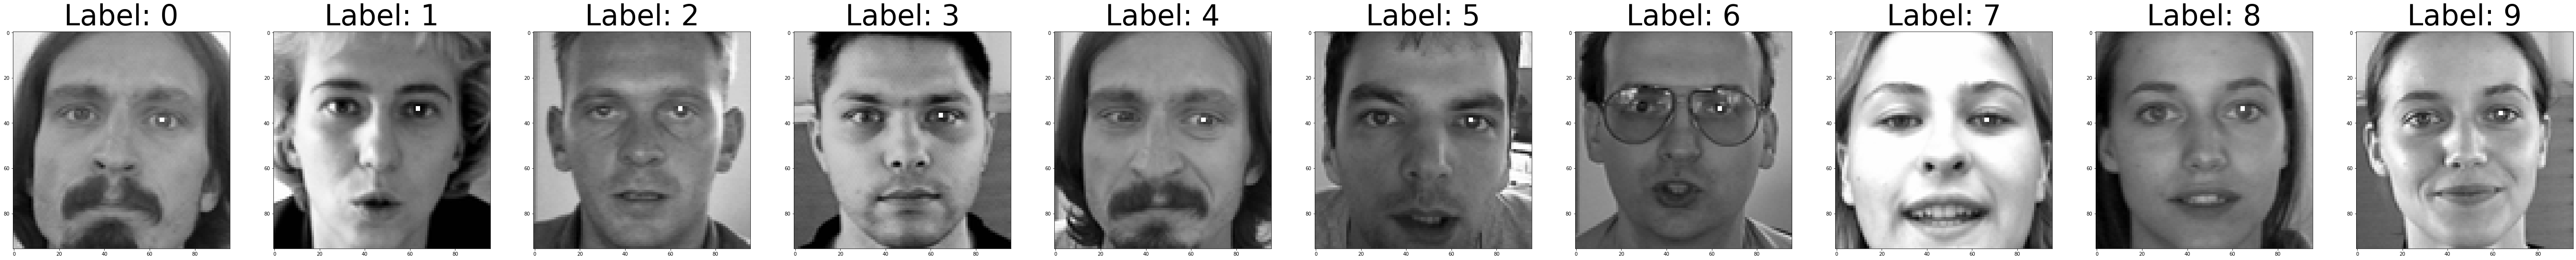

In [9]:
f, ax = plt.subplots(1, 10, figsize=(96,96))

for i in range (0, 10) :
    # print(df.iloc[i,30].shape)
    leftEyeX = df.iloc[i,0]
    leftEyeY = df.iloc[i,1]
    # tempArr = df.iat[i,30] # This is a shallow copy since when i changed tempArr it conversely changes the og dataframe
    tempArr = copy.deepcopy(df.iat[i,30])
    
    for j in range(-1,1):
        for k in range(-1,1):
            tempArr[(int)(leftEyeY+k),(int)(leftEyeX+j)] = 255
    # Numpy Arrays got their indexes backwards idfk
            
    # df.iat[i,30] = tempArr

    ax[i].imshow(tempArr, cmap='gray')
    ax[i].set_title( "Label: {}".format(i), fontsize=60)
print(" All Left Eye centers have had the pixels at their coordinates changed to white")


In [10]:
print(df.shape)
tempX = copy.deepcopy(df["Image"])
tempX = tempX / 255 # Normalized
tempY = copy.deepcopy(df.loc[: , "left_eye_center_x":"mouth_center_bottom_lip_y"])

trainPercentage = 0.9
numTrain = int(trainPercentage * df.shape[0])
xTrain = tempX[:numTrain][:]
yTrain = tempY[:numTrain][:] 
# slice indexing is not inclusive so should be fine
xTest = tempX[numTrain:][:]
yTest = tempY[numTrain:][:]


# print statements to just help me understand how the data is formatted

# print(df["Image"][:1])
# print(f" xTest is {xTrain.shape}")
# print(f" yTest is {yTest.shape}")

# print(xTrain[:1])
# print(yTrain[:1])


(2140, 31)


In [11]:

# Reshaping the dataframe so it is properly shaped

xTra = np.stack(xTrain.values)

xTra = xTra.reshape(xTra.shape[0],96, 96) # HARDCODED?
yTra = np.stack(yTrain.values)
yTra = yTra / 96


xTest = np.stack(xTest.values)

xTest = xTest.reshape(xTest.shape[0],96, 96) # HARDCODED?
yTest = np.stack(yTest.values)
yTest = yTest / 96 # normalized


print("xTra shape: {}".format(xTra.shape))
print("xTest shape: {}".format(xTest.shape))
print("yTra shape: {}".format(yTra.shape))
print("yTest shape: {}".format(yTest.shape))

    
def showImage(xDataset, yDataset, index): 
    img = xDataset[index]
    keypoints = yDataset[index][:]
    xKeypoints = keypoints[::2] * 96
    yKeypoints = keypoints[1::2] * 96
    plt.imshow(img, cmap='gray')
    plt.scatter(xKeypoints, yKeypoints, c = 'red')
    plt.show()

xTra shape: (1926, 96, 96)
xTest shape: (214, 96, 96)
yTra shape: (1926, 30)
yTest shape: (214, 30)


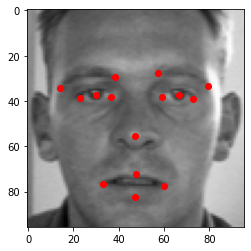

In [12]:
showImage(xTra, yTra, 480)

In [13]:
print(tf.keras.__version__)

from deeplabv3plusCopy import deeplabv3_plus
from dsntLambda import js_reg_loss

2.9.0


In [14]:
#tf.executing_eagerly()
# tf.compat.v1.disable_eager_execution()


# Huge Shoutout to user "off99555" for helping with dsnt implementation with keras model
# https://github.com/ashwhall/dsnt/blob/fab01af2792f98c00b2a0fa1e8acf314b0942185/dsnt.py

model = deeplabv3_plus(input_shape=(96,96,1),out_stride=16,num_classes=15) # wasnt sure if num_classes is number of landmarks or 
#model.summary()


input shape is the following: 96 96 1

output_shape: 6 

----------------
final shape of deeplab model (None, 96, 96, 15)
----------------


In [15]:
print(yTra[0][:2])
print(yTra.shape)

# 30
yTra = yTra.reshape(yTra.shape[0],15,2,order='C')
yTest = yTest.reshape(yTest.shape[0],15,2,order='C')

# Reshapes the landmarks from being organized as [ x1 ,y1 , x2 ,y2 .... x15,y 15] 
# to  [ x1, y1  ]
#     [ x2, y2  ]
#.    [ .....   ]
#.    [ x15, y15]

print(yTra[0][:2][:])
print(yTra.shape)

# def dsnt_loss(y_true, y_pred):
    
    # add regularization loss here later ig?
    
#     return loss
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# to Stop training if there is no improvements

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

#"huber_loss" loss was about like 45.something but with mean_square_error is like 2000

model.fit(xTra, yTra, batch_size=32, epochs=25, callbacks=[callback])

inputs = model.input   
outputs= model.get_layer('last').output


[0.68784962 0.40627368]
(1926, 30)
[[0.68784962 0.40627368]
 [0.31486466 0.37939248]]
(1926, 15, 2)
Epoch 1/25
61/61 [==============================] - 48s 668ms/step - loss: 0.0183 - accuracy: 0.9555
Epoch 2/25
61/61 [==============================] - 41s 672ms/step - loss: 0.0146 - accuracy: 0.9751
Epoch 3/25
61/61 [==============================] - 40s 645ms/step - loss: 0.0144 - accuracy: 0.9760
Epoch 4/25
61/61 [==============================] - 40s 654ms/step - loss: 0.0143 - accuracy: 0.9784
Epoch 5/25
61/61 [==============================] - 39s 634ms/step - loss: 0.0142 - accuracy: 0.9792
Epoch 6/25
61/61 [==============================] - 39s 632ms/step - loss: 0.0142 - accuracy: 0.9803
Epoch 7/25
61/61 [==============================] - 39s 638ms/step - loss: 0.0142 - accuracy: 0.9801
Epoch 8/25
61/61 [==============================] - 39s 646ms/step - loss: 0.0141 - accuracy: 0.9820
Epoch 9/25
61/61 [==============================] - 41s 671ms/step - loss: 0.0141 - accuracy

NameError: name 'Model' is not defined

In [17]:
# Evalution 
pureDLV3 = Model(inputs,outputs)



print(xTest[0][0][0])
print(yTest[0][0][0])
results = model.evaluate(xTest, yTest, batch_size=32)
print("test loss, test acc:", results)


0.023529411764705882
0.6975281201583333
7/7 [==============================] - 4s 284ms/step - loss: 0.0148 - accuracy: 0.9751
test loss, test acc: [0.014816107228398323, 0.9750779271125793]


7/7 [==============================] - 1s 188ms/step
[[0.69752812 0.4250522 ]]
(214, 15, 2)
[[0.6049888  0.44421998]]
size of heatmaps (214, 96, 96, 15)
(214, 96, 96, 15)
(214, 15, 96, 96)


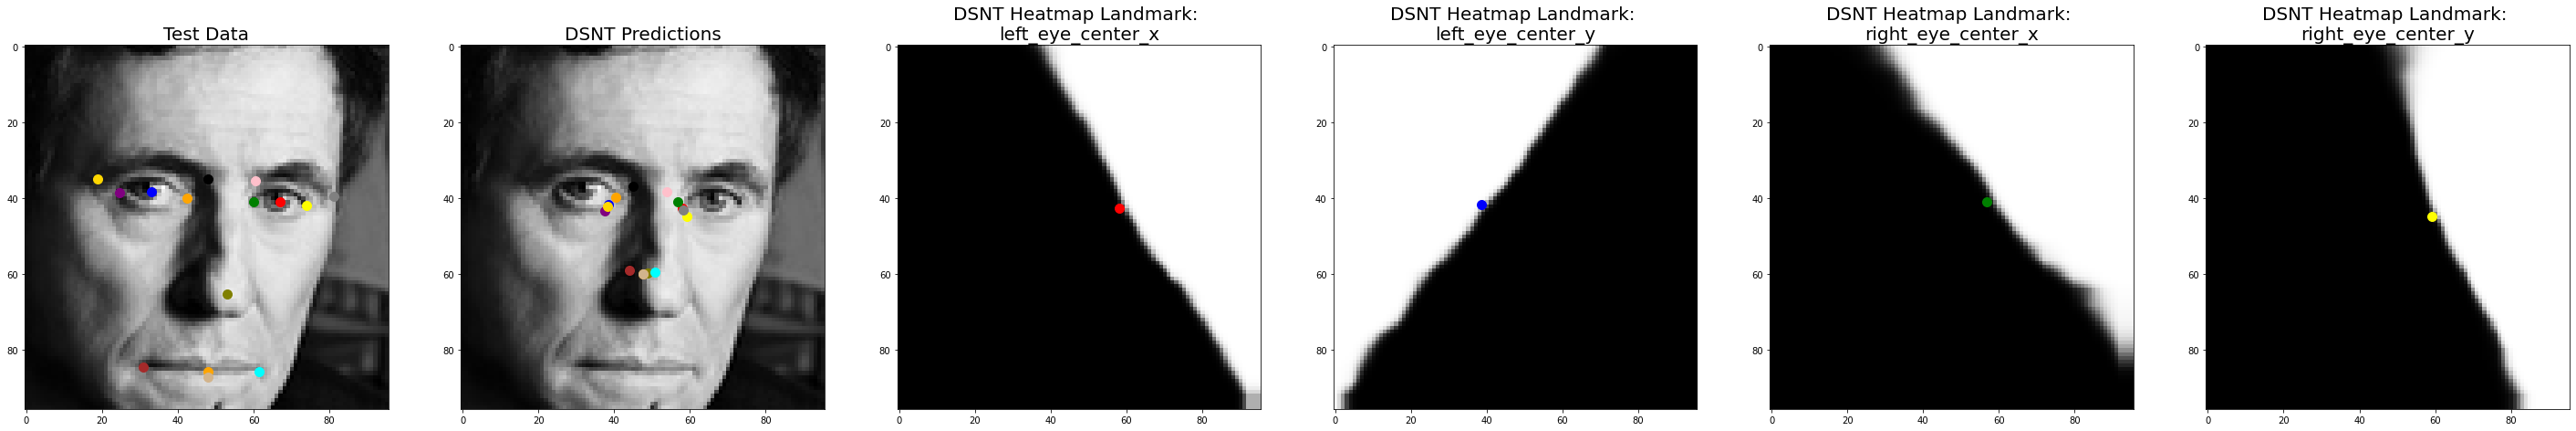

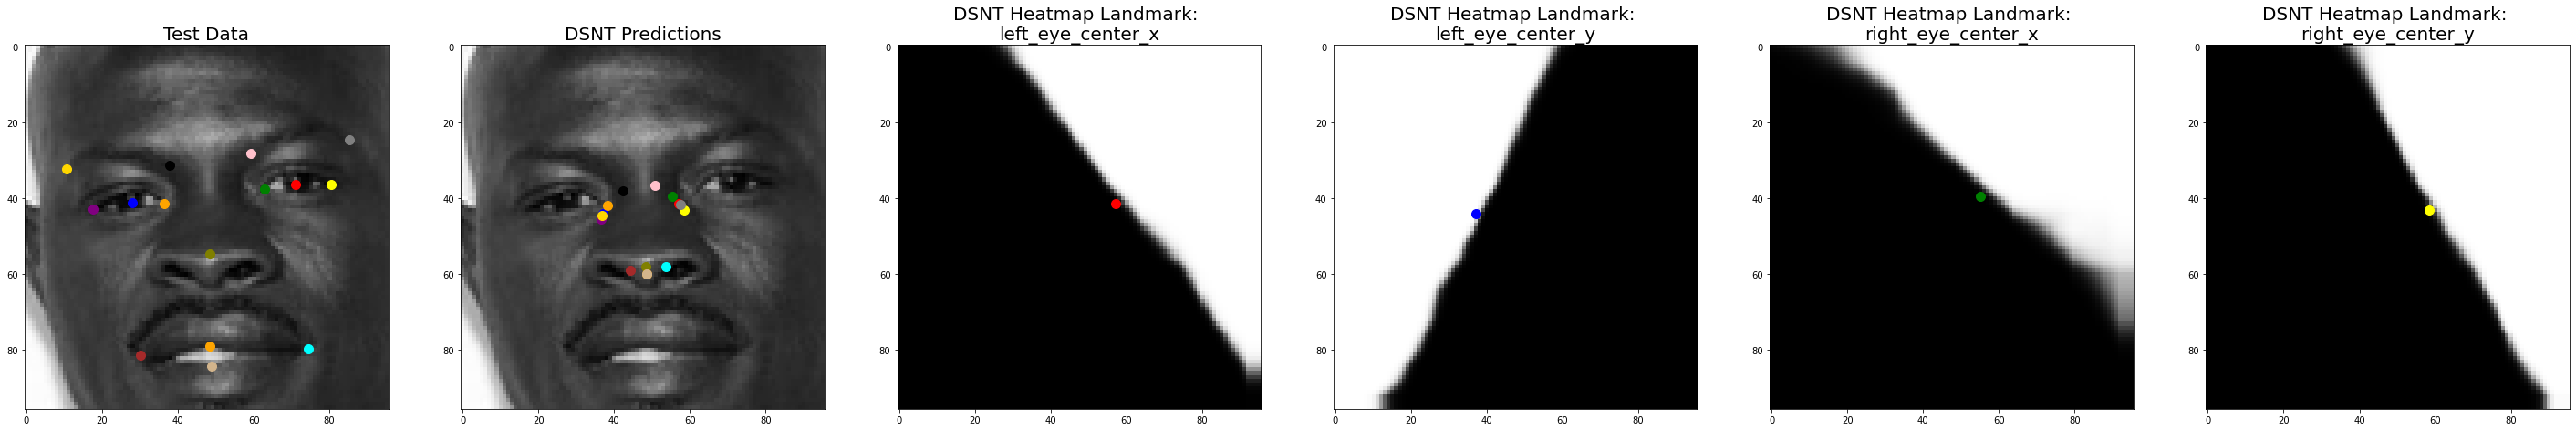

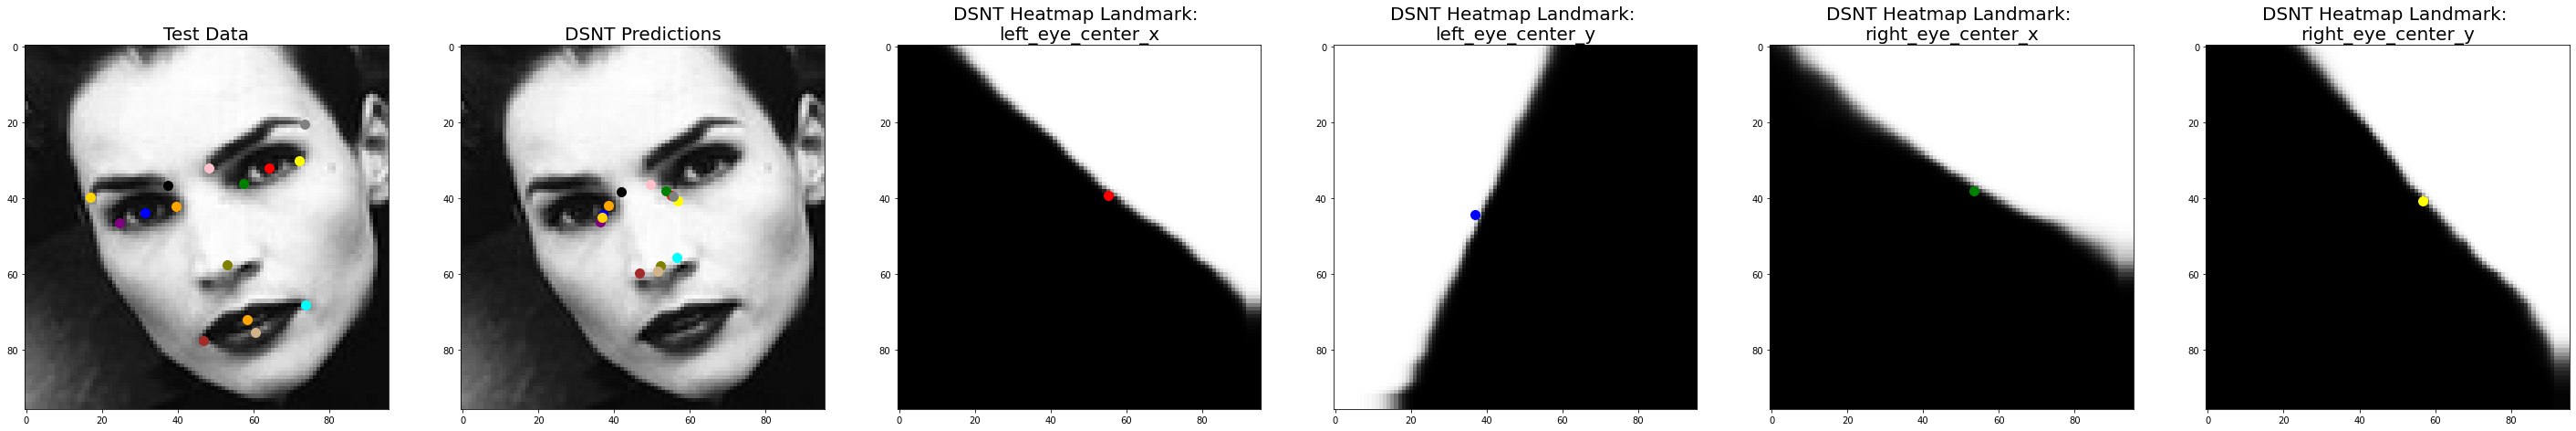

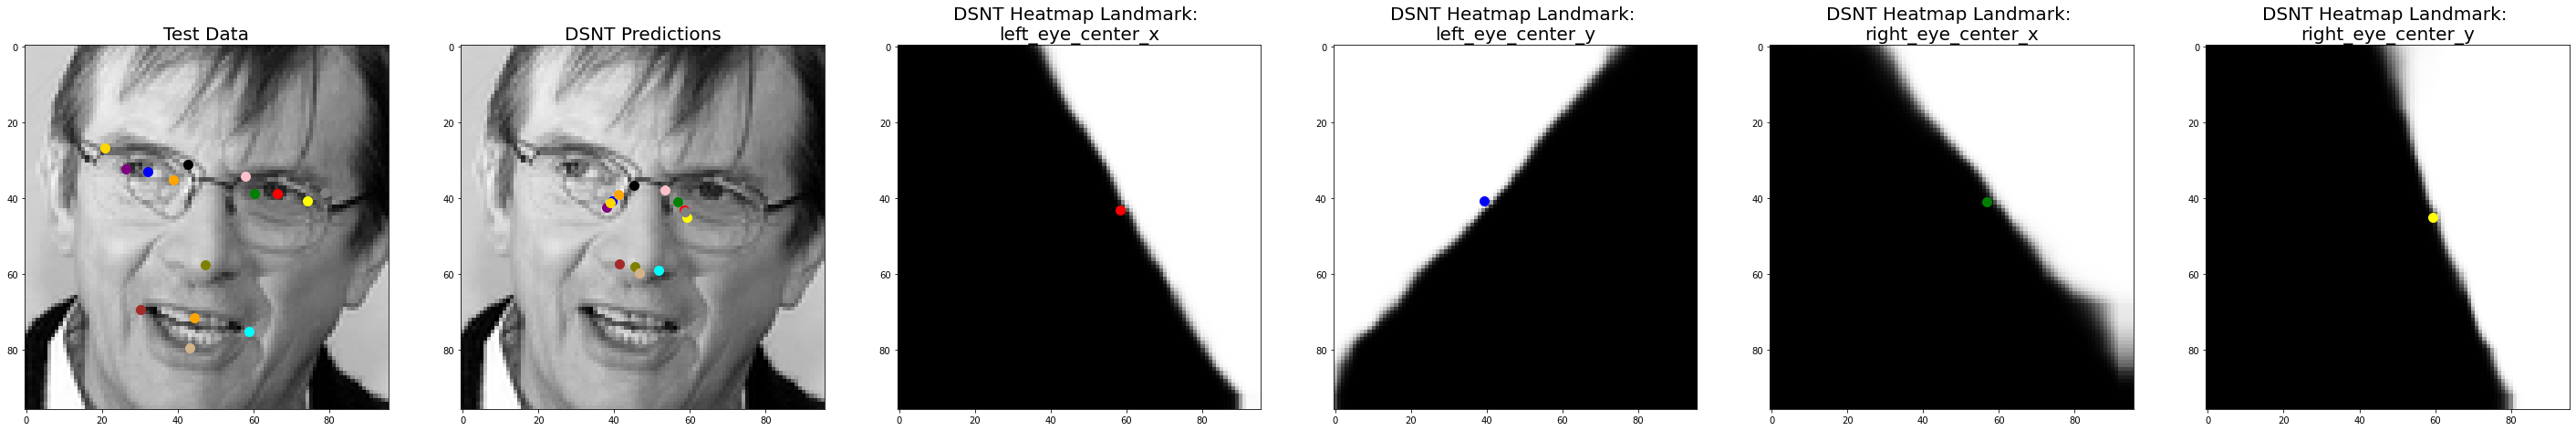

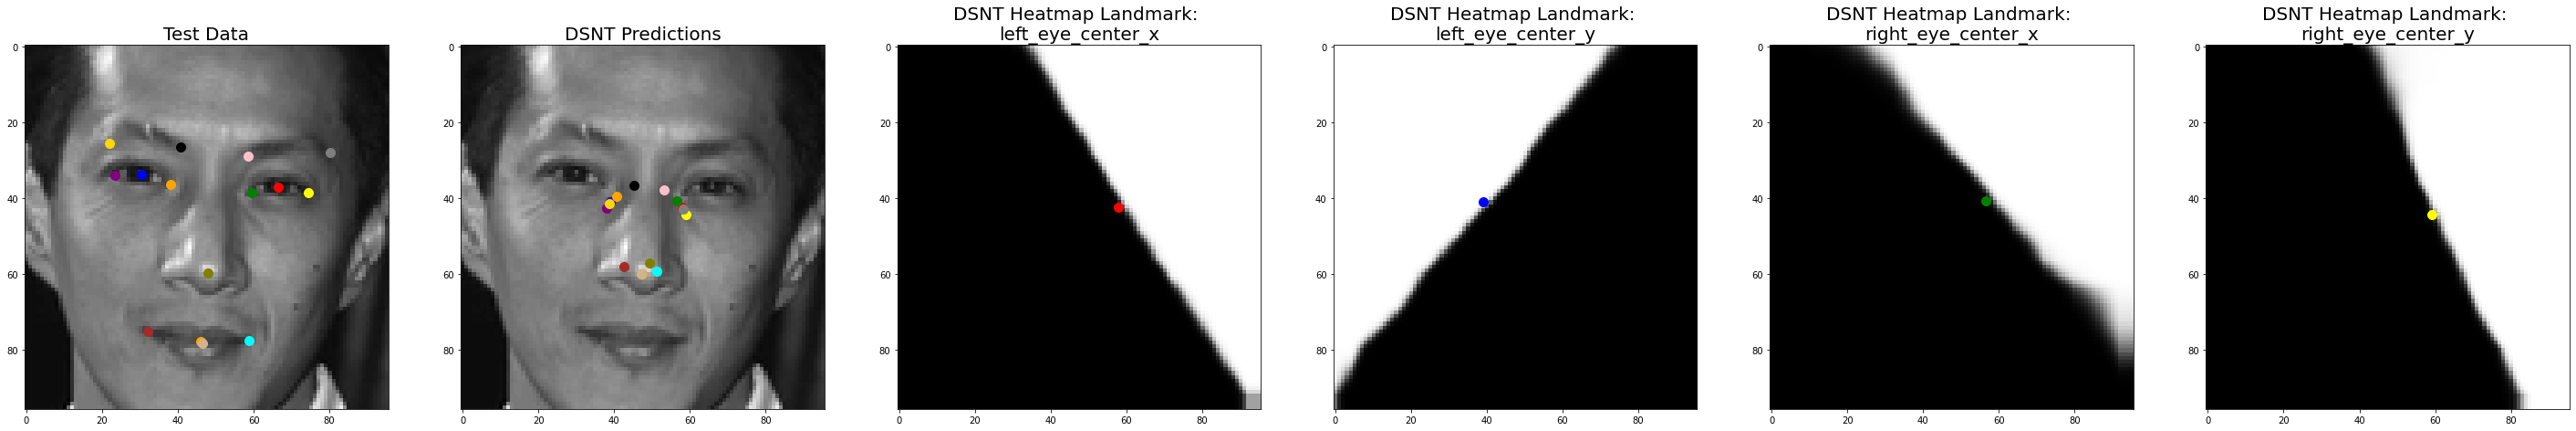

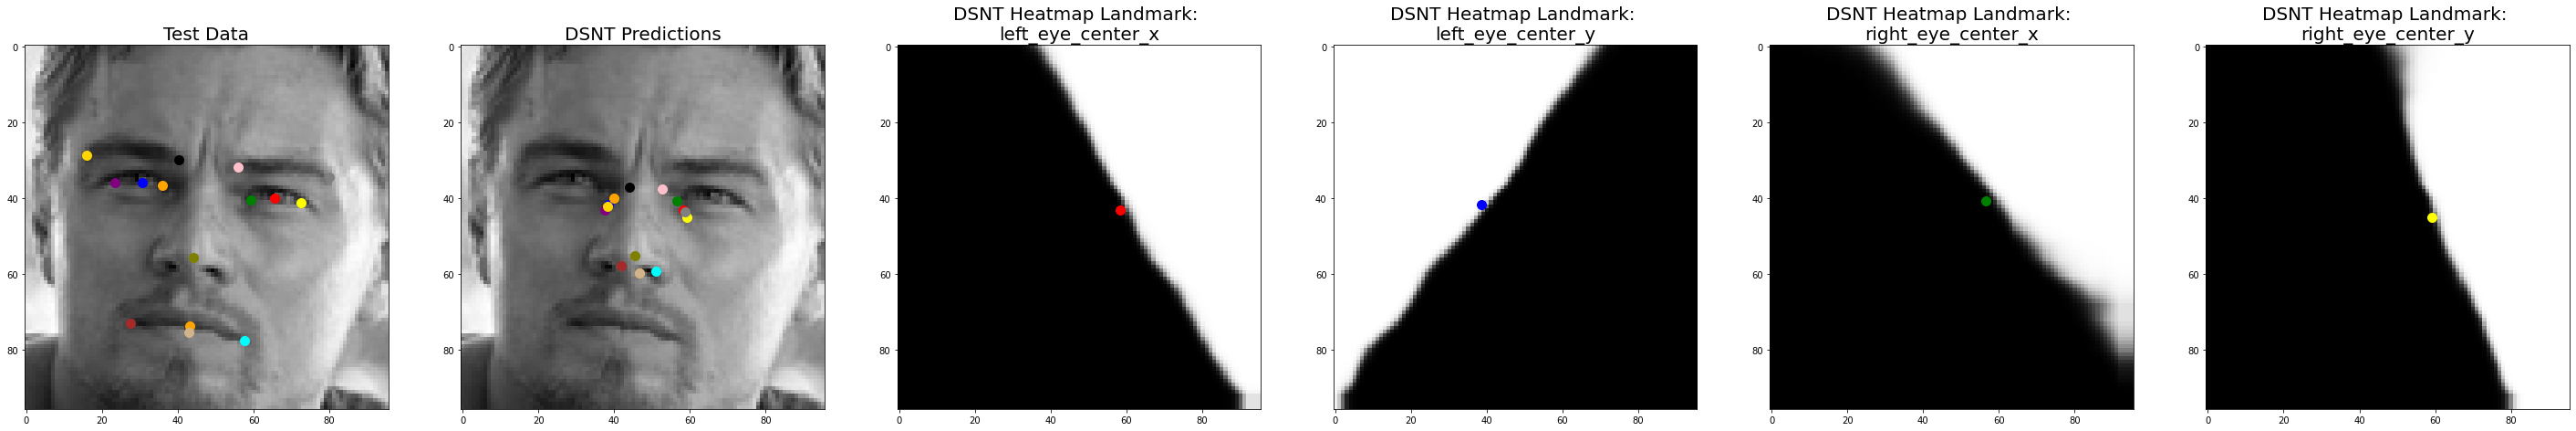

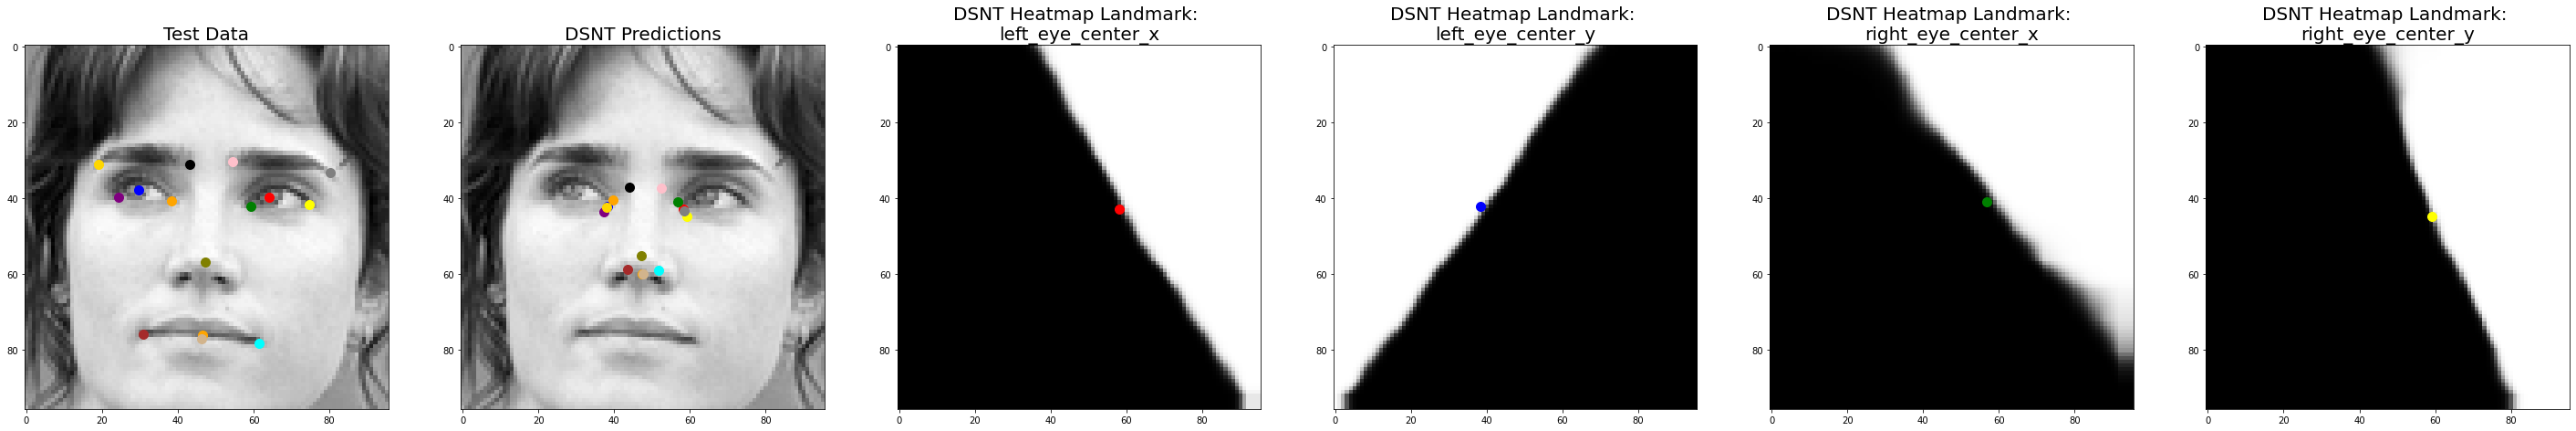

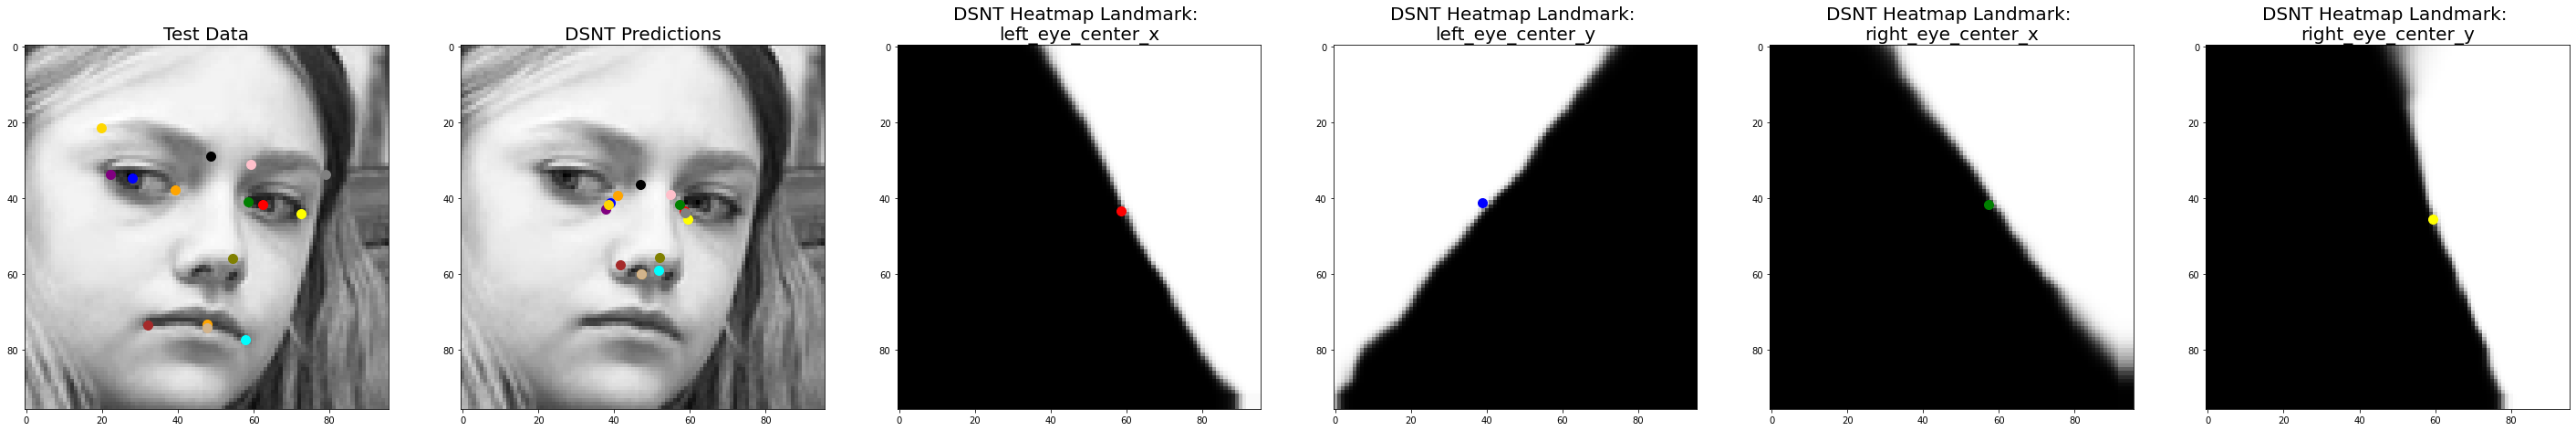

In [56]:
# Some visualizations
predictions = model.predict(xTest)
predictionPts =copy.deepcopy(predictions)
predictionPts *= 96
yTestPts = copy.deepcopy(yTest)
yTestPts *=96

dplbPredicts = pureDLV3.predict(xTest)

print(yTest[0][:1][:])
print(predictions.shape)
print(predictions[0][:1][:])

print("size of heatmaps {}".format(dplbPredicts.shape))

# dplbPredicts = np.reshape(dplbPredicts,(dplbPredicts.shape[0],dplbPredicts.shape[3],dplbPredicts.shape[1],dplbPredicts.shape[2]))
# test
newPredicts = np.einsum('ijkl->iljk',dplbPredicts )
print(dplbPredicts.shape)
print(newPredicts.shape)


# Format of data is (Row Number aka image associated with, Specific Landmark, X & Y Coordinate)
colorDict = { 0:"red" ,1:"blue" , 2:"green" , 3:"yellow" , 4:"orange" ,
             5:"purple" , 6:"pink" , 7:"gray" , 8:"black" , 9:"gold" ,
             10:"olive" , 11:"cyan" , 12:"brown" , 13:"orange" , 14:"tan" }

for n in range(8):
    f, ax = plt.subplots(1, 6, figsize=(50,50))

    for i in range(15):
        ax[0].scatter(yTestPts[n][i][0], yTestPts[n][i][1],s=100, c = colorDict[i])
    ax[0].imshow(xTest[n], cmap='gray')
    ax[0].set_title( "Test Data", fontsize=20)


    for i in range(15):
        ax[1].scatter(predictionPts[n][i][0], predictionPts[n][i][1],s=100, c = colorDict[i])
    ax[1].imshow(xTest[n], cmap='gray')
    ax[1].set_title( "DSNT Predictions", fontsize=20)
    
    for y in range(4):
        ax[y+2].scatter(predictionPts[n][y][0], predictionPts[n][y][1],s=100, c = colorDict[y])
        ax[y+2].imshow(newPredicts[n][y], cmap='gray')
        ax[y+2].set_title( "DSNT Heatmap Landmark: \n{}".format(df.columns[y]), fontsize=20 )
        
    
    